Run 1
1492 flat images and 1508 non-flat images in training set.
Epoch: 0
Cost: 0.6931471785599431
Execution time: 0.5525031089782715
Total execution for 26 Epochs: 0.5525031089782715
Best weights after epoch 25 with a cost of 0.3223839691836085
508 flat images and 492 non-flat images in test set.
[[1357  151]
 [ 276 1216]]
Training Accuracy: 85.76666666666667 %
[[434  58]
 [103 405]]
Testing Accuracy: 83.9 %
Run 2
1513 flat images and 1487 non-flat images in training set.
Epoch: 0
Cost: 0.6931471785599431
Execution time: 0.0
Total execution for 11 Epochs: 0.0
Best weights after epoch 9 with a cost of 0.3350666691728135
487 flat images and 513 non-flat images in test set.
[[1320  167]
 [ 268 1245]]
Training Accuracy: 85.5 %
[[449  64]
 [ 88 399]]
Testing Accuracy: 84.8 %
Run 3
1522 flat images and 1478 non-flat images in training set.
Epoch: 0
Cost: 0.6931471785599431
Execution time: 0.0010004043579101562
Total execution for 24 Epochs: 0.0010004043579101562
Best weights after epoch 22 

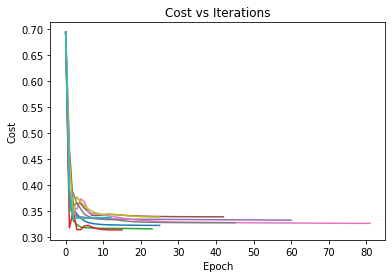

In [5]:
import glob
from PIL import Image, ImageFilter
import os
import random
import time

import numpy as np
import matplotlib.pyplot as plt
from numba import jit


class DataLoader:
    def __init__(self, path):
        self.source = path
        self.samples = []
        self.calculated_features = []
        self.load_data()

    def load_data(self):
        files = glob.glob(self.source + '/*.png')

        for file in files:
            img = Image.open(file).convert('L')
            img_h = np.array(img.histogram())
            var = np.var(img_h)
            img = img.filter(ImageFilter.FIND_EDGES)
            img_array = np.array(img)
            mean = np.sum(img_array) / (64 * 64)
            binary_img = np.where(img_array > mean, 1, 0)
            edge_pixel_sum = np.sum(binary_img)

            splits = file.split('\\')

            class_and_index = splits[-1]
            label_name, _ = class_and_index.split('_', 2)
            label = None
            if label_name == 'f':
                label = 1
            elif label_name == 'nf':
                label = 0
            else:
                raise SyntaxError('Invalid class label detected')
            self.calculated_features.append(np.array([var, edge_pixel_sum]))
            # self.samples.append([img, label])
            self.samples.append([binary_img, label])

        index = 0
        for sample in self.samples:
            img_array = np.array(sample[0])
            img_vector = img_array.ravel()
            img_vector = np.array([])
            # self.calculated_features[index] = np.array([])
            sample_vector = np.hstack((img_vector, self.calculated_features[index]))
            self.samples[index][0] = sample_vector
            index += 1


@jit(nopython=True, parallel=True)
def sigmoid(t):
    return 1 / (1 + np.exp(-t))


@jit(nopython=True, parallel=True)
def regularized_cross_entropy_cost(y, weights, preds, lam, log_eps=1e-9):
    return -1 / (len(y)) * np.sum(y * np.log(preds + log_eps) + (1 - y) * np.log(
        1 - preds + log_eps))


def find_gradient_numerically(weights, x_bar, y, eps, lam):
    gradients = []
    preds = sigmoid(np.dot(x_bar, weights))
    fx = regularized_cross_entropy_cost(y, weights, preds, lam)
    temp_weights = weights.copy()
    for weight in range(len(weights)):
        temp_weights[weight] += eps
        preds = sigmoid(np.dot(x_bar, temp_weights))
        fx_plus_eps = regularized_cross_entropy_cost(y, temp_weights, preds, lam)
        gradients.append((fx_plus_eps - fx) / eps)
        temp_weights[weight] -= eps
    return np.array(gradients)


def find_closed_form_gradient(weights, x_bar, y, eps, lam):
    gradients = (-1 / y.shape[0]) * np.matmul(x_bar.T, y - sigmoid(np.matmul(x_bar, weights)))
    return np.array(gradients)


@jit(nopython=True, parallel=True)
def find_fast_gradient_numerically(weights, x_bar, y, eps, lam):
    log_eps = 1e-9
    gradients = []
    preds = 1 / (1 + np.exp(-(np.dot(x_bar, weights))))
    fx = regularized_cross_entropy_cost(y, weights, preds, lam)
    temp_weights = weights.copy()
    for weight in range(weights.shape[0]):
        temp_weights[weight] += eps
        preds = 1 / (1 + np.exp(-(np.dot(x_bar, temp_weights))))
        fx_plus_eps = -1 / (y.shape[0]) * np.sum(
            y * np.log(preds + log_eps) + (1 - y) * np.log(1 - preds + log_eps) + lam * np.linalg.norm(weights[1:]))
        gradients.append((fx_plus_eps - fx) / eps)
        temp_weights[weight] -= eps
    return np.array(gradients)


class Model:
    def __init__(self, samples, learning_rate, epsilon, batch_size=32):
        self.x, self.y = zip(*samples)
        self.x = np.array(self.x)
        self.y = np.array(self.y)
        num_samples = len(self.y)
        self.x_bar = np.hstack((np.ones([num_samples, 1]), self.x))
        self.weights = np.zeros([self.x_bar.shape[1]])

        self.lam = 0
        self.eps = epsilon
        self.alpha = learning_rate
        self.iterations = 100000
        self.stop_criterion = 1e-5
        self.iteration_display = 100
        self.batch_size = batch_size

        self.num_batches = int(num_samples / self.batch_size)
        total_rows = self.num_batches * self.batch_size
        temp_x_bar = self.x_bar[:total_rows, :].copy()
        temp_y = self.y[:total_rows].copy()
        self.x_bar_batches = np.split(temp_x_bar, self.num_batches, axis=0)
        self.y_batches = np.split(temp_y, self.num_batches, axis=0)
        self.gradient_descent()

    def gradient_descent(self):
        start = time.time()
        total = 0
        history = []
        for i in range(self.iterations):
            preds = sigmoid(np.dot(self.x_bar, self.weights))
            cost = regularized_cross_entropy_cost(self.y, self.weights, preds, self.lam)

            if i % self.iteration_display == 0:
                end = time.time()
                duration = end - start
                print('Epoch:', i)
                print('Cost:', cost)
                print('Execution time:', duration)
                total += duration
                start = time.time()

            for batch in range(self.num_batches):
                gradient = find_closed_form_gradient(self.weights, self.x_bar_batches[batch], self.y_batches[batch],
                                                     self.eps,
                                                     self.lam)
                gradient_norm = np.linalg.norm(gradient)
                self.weights -= self.alpha / (i + 1) * gradient / gradient_norm
            history.append((cost, self.weights, i))
            if i > 0:
                if np.abs(history[i][0] - history[i - 1][0]) < self.stop_criterion:
                    break
        print('Total execution for', len(history), 'Epochs:', total)
        costs, weights, indices = zip(*history)
        plt.plot(range(len(history)), costs)
        plt.xlabel('Epoch')
        plt.ylabel('Cost')
        plt.title('Cost vs Iterations')
        # plt.show()
        history.sort(key=lambda tup: tup[0])
        print('Best weights after epoch', history[0][2], 'with a cost of', history[0][0])
        self.weights = history[0][1]
        x = 1

    def accuracy(self, test_samples):
        x_tests, y_tests = zip(*test_samples)
        x_bar_tests = np.hstack((np.ones([len(y_tests), 1]), x_tests))
        predictions = sigmoid(np.dot(x_bar_tests, self.weights))
        return Model.confusion_matrix(y_tests, predictions)

    @staticmethod
    def confusion_matrix(actuals, predictions):
        thresh = predictions.round()
        c11 = np.sum(np.logical_not(np.logical_or(actuals, thresh)))
        c12 = np.sum(np.logical_and(np.logical_not(actuals), thresh))
        c21 = np.sum(np.logical_and(actuals, np.logical_not(thresh)))
        c22 = np.sum(np.logical_and(actuals, thresh))
        matrix = np.array([[c11, c12], [c21, c22]])
        return matrix


def main():
    cwd = os.getcwd()
    os.chdir(cwd)

    runs = 10
    accuracies = []
    for run in range(runs):
        print('Run', run + 1)
        dataset = DataLoader(cwd + '/Greyscale Dataset')
        train_test_split = 0.75

        random.shuffle(dataset.samples)
        train_test_split = 0.75
        split_index = round(len(dataset.samples) * train_test_split)
        training_set = dataset.samples[:split_index]
        test_set = dataset.samples[split_index:]

        flat_label_count = 0
        not_flat_label_count = 0
        for sample in training_set:
            if sample[1] == 1:
                flat_label_count += 1
            else:
                not_flat_label_count += 1

        print(flat_label_count, 'flat images and', not_flat_label_count, 'non-flat images in training set.')

        classifier = Model(training_set, 0.001, 1e-7)

        flat_label_count = 0
        not_flat_label_count = 0
        for sample in test_set:
            if sample[1] == 1:
                flat_label_count += 1
            else:
                not_flat_label_count += 1

        print(flat_label_count, 'flat images and', not_flat_label_count, 'non-flat images in test set.')

        confusion_matrix = classifier.accuracy(training_set)
        accuracy = 100 * np.trace(confusion_matrix) / np.sum(confusion_matrix)
        print(confusion_matrix)
        print('Training Accuracy:', accuracy, '%')
        confusion_matrix = classifier.accuracy(test_set)
        print(confusion_matrix)
        accuracy = 100 * np.trace(confusion_matrix) / np.sum(confusion_matrix)
        accuracies.append(accuracy)
        print('Testing Accuracy:', accuracy, '%')

    accuracies = np.array(accuracies)
    mean_accuracy = np.mean(accuracies)
    var_accuracy = np.var(accuracies)
    std_accuracy = np.sqrt(var_accuracy)
    print('Average of Accuracy:', mean_accuracy, '%')
    print('Variance of Accuracy:', var_accuracy)
    print('Standard Deviation of Accuracy:', std_accuracy)


if __name__ == '__main__':
    main()

